# **ETC**

In [8]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import arch
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

# **1. A GARCH Model of Oil Prices**

In [9]:
weekly_oil = pd.read_excel('TAF_3_Modelling_Volatility_PES_oil.xls',index_col=0)
weekly_oil.index = pd.to_datetime(weekly_oil.index)
weekly_oil.index.freq = 'W-FRI'


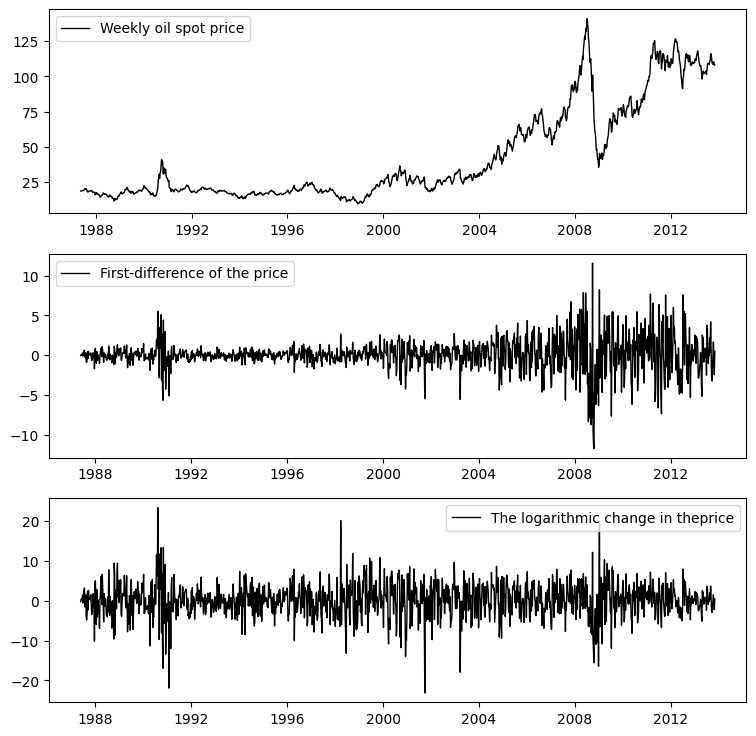

In [10]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 3*3))
axes[0].plot(weekly_oil,color='black',linewidth=1,label='Weekly oil spot price')
axes[0].legend()
axes[1].plot(weekly_oil.diff(),color='black',linewidth=1,label='First-difference of the price')
axes[1].legend()
axes[2].plot(np.log(weekly_oil/weekly_oil.shift(1))*100,color='black',linewidth=1,label='The logarithmic change in theprice')
axes[2].legend()
plt.show()

In [11]:
def adf_test(dataframe):
  result = adfuller(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Critical values: {result[4]}')

adf_test(weekly_oil)
print('---'*40)
adf_test(weekly_oil.diff().dropna())
print('---'*40)
adf_test(np.log(weekly_oil/weekly_oil.shift(1)).dropna()*100)

Statistics: -1.1354866114313085
p-value: 0.7007148498766315
Critical values: {'1%': -3.4351321860409674, '5%': -2.863651979448174, '10%': -2.567894416324791}
------------------------------------------------------------------------------------------------------------------------
Statistics: -9.970477287647263
p-value: 2.247373543622791e-17
Critical values: {'1%': -3.4351321860409674, '5%': -2.863651979448174, '10%': -2.567894416324791}
------------------------------------------------------------------------------------------------------------------------
Statistics: -17.180926385469363
p-value: 6.647698576457893e-30
Critical values: {'1%': -3.4351078301822016, '5%': -2.8636412316027577, '10%': -2.5678886927682663}


In [12]:
def kpss_test(dataframe):
  result = kpss(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'bounded p-value: {result[1]}')
  print(f'Critical values: {result[3]}')

kpss_test(weekly_oil)
print('---'*40)
kpss_test(weekly_oil.diff().dropna())
print('---'*40)
kpss_test(np.log(weekly_oil/weekly_oil.shift(1)).dropna()*100)

Statistics: 4.850221989568524
bounded p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.08440189249882568
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.07035420343048165
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\김주환\AppData\Local\Temp\ipykernel_10640\2325931609.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(dataframe)
C:\Users\김주환\AppData\Local\Temp\ipykernel_10640\2325931609.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)
C:\Users\김주환\AppData\Local\Temp\ipykernel_10640\2325931609.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)


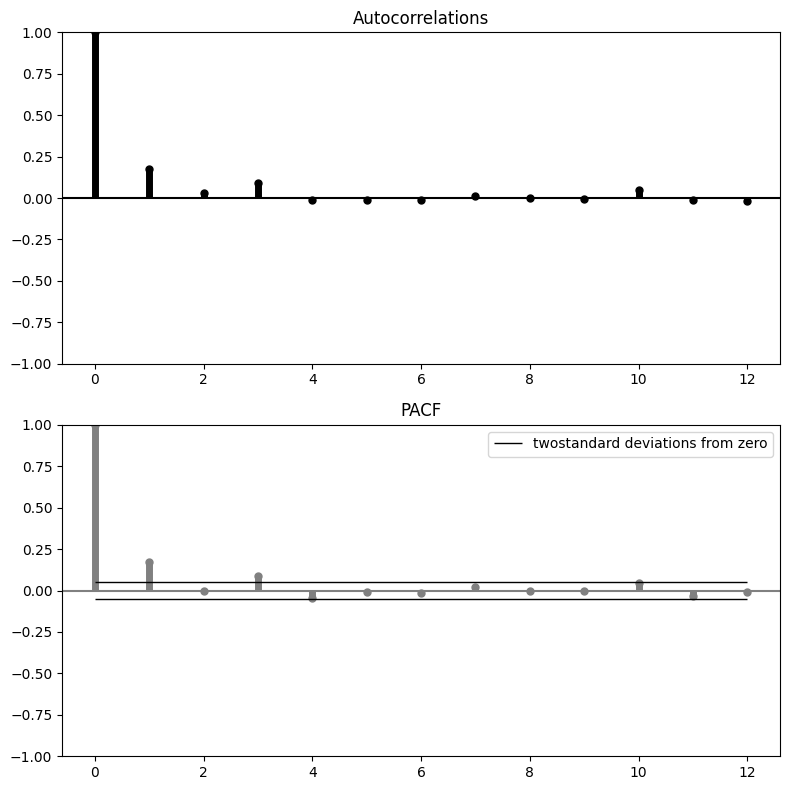

In [13]:
log_change = np.log(weekly_oil/weekly_oil.shift(1)).dropna()*100
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(log_change, lags=12, ax=axes[0], title='Autocorrelations',color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(log_change, lags=12, ax=axes[1], method='ols', title='PACF',color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(log_change)),label='twostandard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(log_change)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

#한번 미분이랑 계절성 지운거 둘다 정상성 만족하는데 계절성 지운거 선택한 이유는 미분을 안하는게 정보의 손실이 없어서 더 좋다

In [14]:
res_1 = ARIMA(endog = log_change, order=(0,0,[1,3]), trend='c').fit(method='innovations_mle')
print('MA([1,3])')
for param_name, param in zip(res_1.params.index, res_1.params):
  coef = round(param,2)
  t_stats = round(res_1.tvalues[param_name],2)
  print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')

residuals = res_1.resid
acf_d = acf(residuals, nlags=8)[1:]
print('ACF of the residuals')
print(acf_d)
squared_resids = residuals**2
acf_d_2 = acf(squared_resids, nlags=8)[1:]
print('ACF of the squared residuals')
print(acf_d_2)

#상수항은 설명력이 없음. 이동평균 1과 3은 설명력을 가짐, 잔차분산이 매우 큼으로 잔차끼리 상관이 존재하여 GARCH모델을 써야 함.

MA([1,3])
[const] = coef:0.13, t_stats:0.9
[ma.L1] = coef:0.18, t_stats:9.31
[ma.L3] = coef:0.09, t_stats:4.6
[sigma2] = coef:16.98, t_stats:41.3
ACF of the residuals
[ 0.00189868  0.01249434 -0.00166612 -0.00924516 -0.0133628  -0.00787883
  0.01006452  0.00517871]
ACF of the squared residuals
[0.18257964 0.16854588 0.1422242  0.15950048 0.12322461 0.14544861
 0.1795277  0.14800551]


In [15]:
print('the MecLeod-Li test')
print(sm.stats.acorr_ljungbox(squared_resids, lags=[1,2,3,4,5,6,7,8]))
res_2 = ARIMA(endog = squared_resids, order=(4,0,0), trend='c').fit(method='innovations_mle')
hypotheses = '(ar.L1 = 0), (ar.L2 = 0), (ar.L3 = 0), (ar.L4 = 0)'
# This tests that each coefficient is jointly statistically significantlydifferent from zero.
print(res_2.f_test(hypotheses))

for param_name, param in zip(res_2.params.index, res_2.params):
  coef = round(param,2)
  t_stats = round(res_2.tvalues[param_name],2)
  print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')

#Q test의 귀무가설이 기각되어버림.

the MecLeod-Li test
      lb_stat     lb_pvalue
1   46.136163  1.103134e-11
2   85.481009  2.741794e-19
3  113.516855  1.920326e-24
4  148.803137  3.674428e-31
5  169.879338  7.741884e-35
6  199.264787  2.720756e-40
7  244.066239  5.072505e-49
8  274.538246  1.068735e-54
<F test: F=75.96647448296056, p=nan, df_denom=inf, df_num=4>
[const] = coef:16.94, t_stats:4.99
[ar.L1] = coef:0.13, t_stats:8.05
[ar.L2] = coef:0.11, t_stats:8.0
[ar.L3] = coef:0.08, t_stats:5.03
[ar.L4] = coef:0.11, t_stats:6.63
[sigma2] = coef:1343.81, t_stats:83.25


In [18]:
# Fitting GARCH(1,1) model
res_3 = ARIMA(endog = log_change, order=(0,0,1), trend='c').fit(method='innovations_mle')
print('A MA(1) conditional mean model')

for param_name, param in zip(res_3.params.index, res_3.params):
  coef = round(param,2)
  t_stats = round(res_3.tvalues[param_name],2)
  print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')

model = arch.arch_model(res_3.resid,vol = 'GARCH', p = 1,q = 1)
print(model)
print('-----------')
garch_results = model.fit(disp = 'off', show_warning = False)
print(garch_results.summary())

A MA(1) conditional mean model
[const] = coef:0.13, t_stats:0.97
[ma.L1] = coef:0.18, t_stats:9.6
[sigma2] = coef:17.14, t_stats:41.61
Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution)
-----------
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3796.10
Distribution:                  Normal   AIC:                           7600.19
Method:            Maximum Likelihood   BIC:                           7621.12
                                        No. Observations:                 1381
Date:                Sat, Sep 23 2023   Df Residuals:                     1380
Time:                        13:04:23   Df Model:                            1
                               

C:\Users\김주환\Documents\GitHub\Financial_Engineering\venv\Lib\site-packages\arch\univariate\base.py:1894: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
C:\Users\김주환\Documents\GitHub\Financial_Engineering\venv\Lib\site-packages\arch\univariate\base.py:1895: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
C:\Users\김주환\Documents\GitHub\Financial_Engineering\venv\Lib\site-packages\arch\univariate\base.py:1896: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be

In [35]:
# ACF of the standardized residuals and standardlized squared residuals
garch11_std_resid = garch_results.std_resid
acf_d = acf(garch11_std_resid, nlags=8)[1:]
print('ACF of the std residuals')
print(acf_d)
acf_d = acf(garch11_std_resid**2, nlags=8)[1:]
print('ACF of the squared std residuals')
print(acf_d)
print(sm.stats.acorr_ljungbox(garch11_std_resid, lags=[4,8]))
print(sm.stats.acorr_ljungbox(garch11_std_resid**2, lags=[4,8]))


ACF of the std residuals
[ 0.05529489 -0.00389773  0.04059871 -0.01441606 -0.03350124 -0.02191024
 -0.00327688 -0.01314317]
ACF of the squared std residuals
[-0.00030731  0.00511315 -0.00211738 -0.00583716 -0.02512703 -0.01331425
 -0.01228585  0.00200178]
    lb_stat  lb_pvalue
4  6.825416   0.145407
8  9.305282   0.317201
    lb_stat  lb_pvalue
4  0.089814   0.999021
8  1.427792   0.993843


In [36]:
res_ar4 = ARIMA(endog = garch11_std_resid, order=(4,0,0), trend='c').fit(method='innovations_mle')
res_ar4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              std_resid   No. Observations:                 1381
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1953.910
Date:                Thu, 21 Sep 2023   AIC                           3919.819
Time:                        22:20:14   BIC                           3951.202
Sample:                    05-22-1987   HQIC                          3931.559
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.029     -0.162      0.872      -0.062       0.053
ar.L1          0.0567      0.027      2.107      0.035       0.004       0.109
ar.L2         -0.0095      0.027     -0.346      0.729      -0.063       0.044
ar.L3          0.0423      0.028      1.528      0.126      -0.012       0.097
ar.L4         -0.0191      0.027     -0.694      0.488      -0.073       0.035
sigma2         0.9919      0.028     35.426      0.000       0.937       1.047
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               200.49
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.21
Prob(H) (two-sided):                  0.76   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
hypotheses = '(ar.L1 = 0), (ar.L2 = 0), (ar.L3 = 0), (ar.L4 = 0)'
# This tests that each coefficient is jointly statistically significantlydifferent from zero.
print(res_ar4.f_test(hypotheses))


<F test: F=1.8686523708221854, p=nan, df_denom=inf, df_num=4>


# **2. A GARCH Model of the Spread**

In [38]:
quarterly = pd.read_excel('TAF_2_Stationary_Time_Series_PES_quarterly.xls',index_col=0)
usbond, tbill = quarterly['r5'], quarterly['Tbill']
spread = usbond - tbill
spread.index = pd.to_datetime(spread.index)
spread.index.freq = 'QS-OCT'


C:\Users\김주환\AppData\Local\Temp\ipykernel_6168\3884903393.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spread.index = pd.to_datetime(spread.index)


<Axes: xlabel='DATE'>

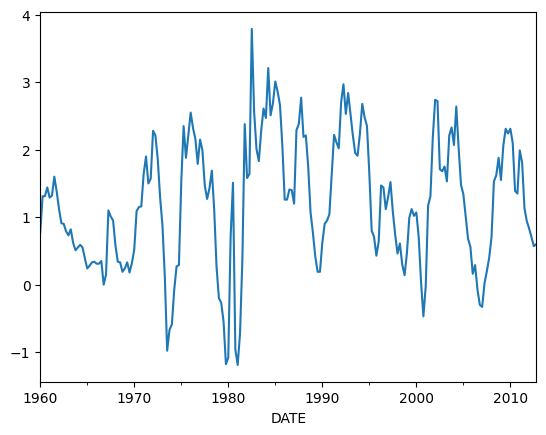

In [39]:
spread.plot()

In [40]:
model = ARIMA(endog = spread, order=(2,0,[1,7]), trend='c').fit(method='innovations_mle') # ARMA[2,(1,7)]
for param_name, param in zip(model.params.index, model.params):
  coef = round(param,2)
  t_stats = round(model.tvalues[param_name],2)
  print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')

[const] = coef:1.19, t_stats:5.74
[ar.L1] = coef:0.34, t_stats:3.24
[ar.L2] = coef:0.4, t_stats:4.18
[ma.L1] = coef:0.78, t_stats:10.93
[ma.L7] = coef:-0.14, t_stats:-3.73
[sigma2] = coef:0.21, t_stats:15.1


# **3. Formal Tests for ARCH Errors**

In [41]:
arma_2_17_resid = model.resid
acf_d = acf(arma_2_17_resid**2, nlags=8)[1:]
print('ACF of the squared residuals')
print(acf_d)
print(sm.stats.acorr_ljungbox(arma_2_17_resid**2, lags=[4,8]))


ACF of the squared residuals
[0.04102062 0.17552854 0.18171439 0.31826154 0.0660248  0.02399291
 0.37925097 0.12862706]
     lb_stat     lb_pvalue
4  36.278726  2.535726e-07
8  72.871303  1.314764e-12


In [42]:
print('the McLeod-Li test')
res = ARIMA(endog = arma_2_17_resid**2, order=(7,0,0), trend='c').fit(method='innovations_mle')
hypotheses = '(ar.L1 = 0), (ar.L2 = 0), (ar.L3 = 0), (ar.L4 = 0), (ar.L5 = 0),(ar.L6 = 0), (ar.L7 = 0)'
# This tests that each coefficient is jointly statistically significantlydifferent from zero.
print(res.f_test(hypotheses))
for param_name, param in zip(res.params.index, res.params):
  coef = round(param,2)
  t_stats = round(res.tvalues[param_name],2)
  print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')

the McLeod-Li test
<F test: F=16.282197748895676, p=nan, df_denom=inf, df_num=7>
[const] = coef:0.2, t_stats:1.1
[ar.L1] = coef:-0.02, t_stats:-0.15
[ar.L2] = coef:0.14, t_stats:4.52
[ar.L3] = coef:0.09, t_stats:0.89
[ar.L4] = coef:0.25, t_stats:4.62
[ar.L5] = coef:-0.03, t_stats:-0.22
[ar.L6] = coef:-0.09, t_stats:-0.72
[ar.L7] = coef:0.3, t_stats:4.08
[sigma2] = coef:0.19, t_stats:31.49


# **4. Alternative Estimates of the Model**

In [7]:
# The installation takes about eight to ten minutes.
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
robjects.r("install.packages(\"gdata\") ")
robjects.r("install.packages(\"rugarch\") ")
robjects.r('library("gdata")')
robjects.r('library("rugarch")')
robjects.r("library('zoo')")
robjects.r("install.packages('zoo')")
robjects.r("install.packages(\"readxl\")")
robjects.r('library("readxl")')

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()


ModuleNotFoundError: No module named 'rpy2'

In [49]:
robjects.r('data = read.xls("TAF_2_Stationary_Time_Series_PES_quarterly.xls\")')

robjects.r('data$DATE = as.yearqtr(data$DATE)')
spread = robjects.r('data$spread = data$r5-data$Tbill')
index = robjects.r('data$DATE')

In [ ]:
spread = pd.Series(spread,index=index)
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axes.plot(spread,color='black',linewidth=1,label='The interest rate spread')
axes.hlines(xmin=spread.index[0],xmax=spread.index[-1],y=0,color='gray',linewidth=1)
axes.legend()


In [ ]:
robjects.r('spec.arma27garch11 = ugarchspec(mean.model=list(armaOrder=c(2,7)),variance.model=list(garchOrder=c(1,1),model="sGARCH"),fixed.pars=list(ma2=0,ma3=0,ma4=0,ma5=0,ma6=0))')
fit_arma27garch11 = robjects.r('fit.arma27garch11 = ugarchfit(spec.arma27garch11,data=data$spread,solver="gosolnp")')
print(fit_arma27garch11)
# Omega means the constant. Alpha means the MA term. Beta means the AR term.

In [ ]:
std_resid = robjects.r("fit.arma27garch11@fit$z")

In [ ]:
acf_d = acf(std_resid, nlags=8)[1:]
print('ACF of the std residuals')
print(acf_d)
print(sm.stats.acorr_ljungbox(std_resid, lags=[4,8]))
print('ACF of the squared std residuals')
acf_d = acf(np.array(std_resid)**2, nlags=8)[1:]
print(acf_d)
print(sm.stats.acorr_ljungbox(std_resid**2, lags=[4,8]))


In [ ]:
print('the MecLeod-Li test')
res = ARIMA(endog = pd.Series(std_resid**2), order=(2,0,0), trend='c').fit(method='innovations_mle')
hypotheses = '(ar.L1 = 0), (ar.L2 = 0)'
# This tests that each coefficient is jointly statistically significantlydifferent from zero.
print(res.f_test(hypotheses))
for param_name, param in zip(res.params.index, res.params):
  coef = round(param,2)
  t_stats = round(res.tvalues[param_name],2)
  print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')


In [ ]:
 robjects.r('spec.arma27garch12 = ugarchspec(mean.model=list(armaOrder=c(2,7)),variance.model=list(garchOrder=c(1,2),model="sGARCH"),fixed.pars=list(ma2=0,ma3=0,ma4=0,ma5=0,ma6=0))')
fit_arma27garch12 = robjects.r('fit.arma27garch12 = ugarchfit(spec.arma27garch12,data=data$spread,solver="gosolnp")')
print(fit_arma27garch12)

In [ ]:
robjects.r('spec.arma27garch21 = ugarchspec(mean.model=list(armaOrder=c(2,7)),variance.model=list(garchOrder=c(2,1),model="sGARCH"),fixed.pars=list(ma2=0,ma3=0,ma4=0,ma5=0,ma6=0))')
fit_arma27garch21 = robjects.r('fit.arma27garch21 = ugarchfit(spec.arma27garch21,data=data$spread,solver="gosolnp")')
print(fit_arma27garch21)

In [ ]:
 robjects.r('spec.arma27arch2 = ugarchspec(mean.model=list(armaOrder=c(2,7)),variance.model=list(garchOrder=c(2,0),model="sGARCH"),fixed.pars=list(ma2=0,ma3=0,ma4=0,ma5=0,ma6=0))')
fit_arma27arch2 = robjects.r('fit.arma27arch2 = ugarchfit(spec.arma27arch2,data=data$spread,solver="gosolnp")')
print(fit_arma27arch2)

In [ ]:
std_resid_arma27_arch2 = robjects.r('fit.arma27arch2@fit$z')


In [ ]:
acf_d = acf(std_resid_arma27_arch2, nlags=8)[1:]
print('ACF of the std residuals')
print(acf_d)
print(sm.stats.acorr_ljungbox(std_resid_arma27_arch2, lags=[4,8]))
print('ACF of the squared std residuals')
acf_d = acf(std_resid_arma27_arch2**2, nlags=8)[1:]
print(acf_d)
print(sm.stats.acorr_ljungbox(std_resid_arma27_arch2**2, lags=[4,8]))


In [ ]:
print('the MecLeod-Li test')
res = ARIMA(endog = pd.Series(std_resid_arma27_arch2**2), order=(4,0,0),trend='c').fit(method='innovations_mle')
hypotheses = '(ar.L1 = 0), (ar.L2 = 0), (ar.L3 = 0), (ar.L4 = 0)'
# This tests that each coefficient is jointly statistically significantlydifferent from zero.
print(res.f_test(hypotheses))
for param_name, param in zip(res.params.index, res.params):
  coef = round(param,2)
  t_stats = round(res.tvalues[param_name],2)
  print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')

In [ ]:
robjects.r('spec.arma27arch3 = ugarchspec(mean.model=list(armaOrder=c(2,7)),variance.model=list(garchOrder=c(3,0),model="sGARCH"),fixed.pars=list(ma2=0,ma3=0,ma4=0,ma5=0,ma6=0))')
fit_arma27arch3 = robjects.r('fit.arma27arch3 = ugarchfit(spec.arma27arch3,data=data$spread,solver="gosolnp")')
print(fit_arma27arch3)
std_resid_arma27_arch3 = robjects.r('fit.arma27arch3@fit$z')

In [ ]:
acf_d = acf(std_resid_arma27_arch3, nlags=8)[1:]
print('ACF of the std residuals')
print(acf_d)
print(sm.stats.acorr_ljungbox(std_resid_arma27_arch3, lags=[4,8]))
print('ACF of the squared std residuals')
acf_d = acf(std_resid_arma27_arch3**2, nlags=8)[1:]
print(acf_d)
print(sm.stats.acorr_ljungbox(std_resid_arma27_arch3**2, lags=[4,8]))

In [ ]:
# One step-ahead forecast of a conditional mean of spread using theARMA[2,(1,7)] with ARCH(3) errors.
# The forecasting takes about ten minutes.
robjects.r('start = 50')
robjects.r('space = nrow(data)-start')
robjects.r('fore = matrix(NA,ncol=3,nrow=space)')
robjects.r("""
for (i in 1:space) {
  sample = data$spread[1:(length(data$spread)-space+i)]
  spec.arma217arch3 = ugarchspec(mean.model=list(armaOrder=c(2,7),include.mean=TRUE),variance.model=list(garchOrder=c(3,0)),fixed.pars=list(ma2=0,ma3=0,ma4=0,ma5=0,ma6=0))
  fit.arma217arch3 = ugarchfit(spec=spec.arma217arch3,data=sample,solver="hybrid")
  fore.arma217arch3 = ugarchforecast(fit.arma217arch3,n.ahead=1)
  c.mean = fore.arma217arch3@forecast$seriesFor
  lower = c.mean - 2*fore.arma217arch3@forecast$sigmaFor
  upper = c.mean + 2*fore.arma217arch3@forecast$sigmaFor
  fore[i,] = c(c.mean,lower,upper)
  print(i)
}
""")
date_index = robjects.r('fore.date=data$DATE[-c(1:start)]')
forecasts = robjects.r('fore')


In [ ]:
 # plot the results
forecast_df = pd.DataFrame(forecasts,index=date_index,columns=['conditional mean', 'lower bound', 'upper bound'])
plt.figure(figsize=(10,4))
plt.plot(forecast_df['conditional mean'], label='conditional mean',color='black')
plt.plot(forecast_df['lower bound'], label='-2 conditional standarddeviations', color='gray', linestyle='--')
plt.plot(forecast_df['upper bound'], label='+2 conditional standarddeviations', color='gray', linestyle='--')
plt.legend()
plt.show()


# **1. The Model of the Mean**

In [4]:
dt_parser = lambda x: datetime.datetime.strptime(str(x), "%Y:%m:%d")
data = pd.read_excel("TAF_3_Modelling_Volatility_PES_nyse.xlsx",parse_dates=['ENTRY'], date_parser=dt_parser)
data.index = pd.to_datetime(data['ENTRY'])
rate = data['RATE']
print("a mean value")
print(rate.mean())
print("a sample variance")
print(rate.var())

a mean value
0.003025100260996936
a sample variance
1.6374888484409134


C:\Users\김주환\AppData\Local\Temp\ipykernel_10640\2710910923.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_excel("TAF_3_Modelling_Volatility_PES_nyse.xlsx",parse_dates=['ENTRY'], date_parser=dt_parser)


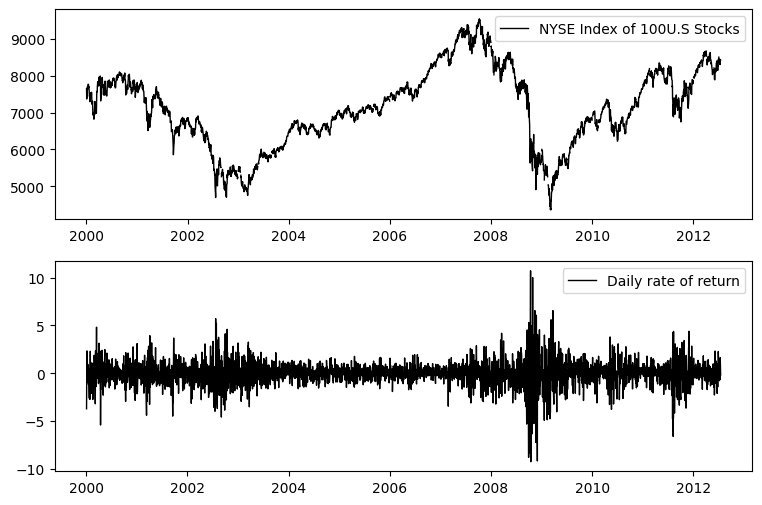

In [5]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 2*3))
axes[0].plot(data['RETURN'],color='black',linewidth=1,label='NYSE Index of 100U.S Stocks')
axes[0].legend()
axes[1].plot(rate,color='black',linewidth=1,label='Daily rate of return')
axes[1].legend()


In [6]:
robjects.r('data = read_excel(\"/content/drive/MyDrive/GARCH/TAF_3_Modelling_Volatility_PES_nyse.xlsx\")')
robjects.r('return = as.numeric(as.character(data$RETURN))')
robjects.r('rate = na.omit(data$RATE)')
x = robjects.r("x=seq(-10,10,0.01)")
y1 = robjects.r('y1=dnorm(x)')
y2 = robjects.r('y2=dt(x,df=3)')


NameError: name 'robjects' is not defined

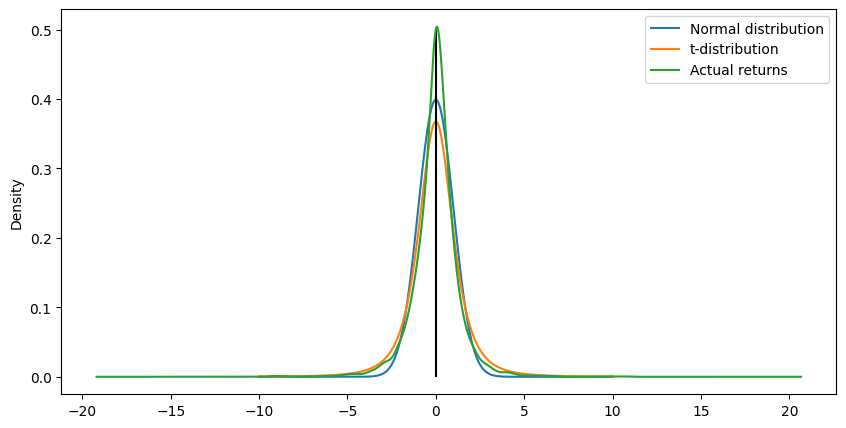

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x,y1, label='Normal distribution')
plt.plot(x,y2, label='t-distribution')
plt.vlines(x=0, ymin=0.5, ymax=0, color='black')
rate.plot(kind='density', label='Actual returns')
plt.legend()

In [ ]:
 acf_nyse_rate = acf(rate.dropna(), nlags=8)[1:]
print(acf_nyse_rate)
print(len(rate.dropna()))


[-0.08939543 -0.04898622  0.01803946 -0.00350624 -0.04102434 -0.01286489
 -0.03719031  0.0496124 ]
3270


In [ ]:
 robjects.r('spec.ar2 = arfimaspec(mean.model=list(armaOrder=c(2,0)))')
fit_ar2 = robjects.r('fit.ar2 = arfimafit(spec.ar2,data=rate)')
print(fit_ar2)
robjects.r('spec.ma1 = arfimaspec(mean.model=list(armaOrder=c(0,1)))')
fit_ma1 = robjects.r('fit.ma1 = arfimafit(spec.ma1,data=rate)')
print(fit_ma1)


*----------------------------------*
*          ARFIMA Model Fit        *
*----------------------------------*
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
       Estimate  Std. Error  t value Pr(>|t|)
mu     0.003221    0.019313   0.1668 0.867524
ar1   -0.094621    0.017481  -5.4127 0.000000
ar2   -0.057468    0.017463  -3.2908 0.000999
sigma  1.272226    0.015732  80.8702 0.000000

Robust Standard Errors:
       Estimate  Std. Error  t value Pr(>|t|)
mu     0.003221    0.018441  0.17469 0.861323
ar1   -0.094621    0.025098 -3.77007 0.000163
ar2   -0.057468    0.037973 -1.51338 0.130184
sigma  1.272226    0.083960 15.15285 0.000000

LogLikelihood : -5427.239 

Information Criteria
------------------------------------
                   
Akaike       3.3219
Bayes        3.3293
Shibata      3.3219
Hannan-Quinn 3.3245

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
                       

# **2. Testing for GARCH errors**

In [24]:
robjects.r('res.ar2 = fit.ar2@fit$residuals')
robjects.r('spec.ar5 = arfimaspec(mean.model=list(armaOrder=c(5,0)))')
fit_ar5 = robjects.r('fit.ar5 = arfimafit(spec.ar5,data=res.ar2^2)')
print(fit_ar5)

NameError: name 'robjects' is not defined

# **3. Alternative Estimates of the Model**

In [25]:
robjects.r('spec.ar2garch11.norm = ugarchspec(mean.model=list(armaOrder=c(2,0)),variance.model=list(garchOrder=c(1,1),model="sGARCH"),distribution.model="norm")')
robjects.r('fit.ar2garch11.norm = ugarchfit(spec.ar2garch11.norm,data=rate)')
fit_ar2_garch11_norm_dist = robjects.r('fit.ar2garch11.norm')
print(fit_ar2_garch11_norm_dist)


NameError: name 'robjects' is not defined

In [ ]:
robjects.r('spec.ar2garch11.t = ugarchspec(mean.model=list(armaOrder=c(2,0)),variance.model=list(garchOrder=c(1,1),model="sGARCH"),distribution.model="std")')
robjects.r('fit.ar2garch11.t = ugarchfit(spec.ar2garch11.t,data=rate)')
fit_ar2_garch11_t_dist = robjects.r('fit.ar2garch11.t')
print(fit_ar2_garch11_t_dist)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.054964    0.012362   4.4463 0.000009
ar1    -0.062179    0.017302  -3.5937 0.000326
ar2    -0.045499    0.017719  -2.5678 0.010235
omega   0.009252    0.002969   3.1166 0.001830
alpha1  0.088743    0.010405   8.5290 0.000000
beta1   0.909353    0.009665  94.0863 0.000000
shape   6.120997    0.699129   8.7552 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.054964    0.011824   4.6483 0.000003
ar1    -0.062179    0.014776  -4.2081 0.000026
ar2    -0.045499    0.018302  -2.4860 0.012919
omega   0.009252    0.002788   3.3188 0.000904
alpha1  0.088743    0.011573   7.6684 0.000000
beta1   0

In [ ]:
 robjects.r('spec.ma2igarch11.t = ugarchspec(mean.model=list(armaOrder=c(0,2)),variance.model=list(garchOrder=c(1,1),model="iGARCH"), distribution.model="std")')
robjects.r('fit.ma2igarch11.t = ugarchfit(spec.ma2igarch11.t,data=rate)')
fit_ma2_igarch11_t_dist = robjects.r('fit.ma2igarch11.t')
print(fit_ma2_igarch11_t_dist)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(0,0,2)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.055235    0.012198   4.5282 0.000006
ma1    -0.063119    0.017243  -3.6606 0.000252
ma2    -0.044445    0.018045  -2.4631 0.013775
omega   0.008640    0.002428   3.5589 0.000372
alpha1  0.090456    0.009548   9.4738 0.000000
beta1   0.909544          NA       NA       NA
shape   6.002517    0.607556   9.8798 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.055235    0.012257   4.5064 0.000007
ma1    -0.063119    0.015628  -4.0389 0.000054
ma2    -0.044445    0.018897  -2.3520 0.018674
omega   0.008640    0.002497   3.4607 0.000539
alpha1  0.090456    0.009518   9.5033 0.000000
beta1   0

In [ ]:
# archpow Indicates whether to use st.deviation (1) or variance (2) in the ARCHin mean regression.
robjects.r('spec.ma2igarchm11.norm = ugarchspec(mean.model=list(armaOrder=c(0,2),archm=TRUE,archpow=2),variance.model=list(garchOrder=c(1,1),model="iGARCH"),distribution.model="std")')
fit_ma2_igarchm11 = robjects.r('fit.ma2igarchm11.norm = ugarchfit(spec.ma2igarchm11.norm,data=rate)')
print(fit_ma2_igarchm11)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(0,0,2)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.045219    0.016115  2.80602 0.005016
ma1    -0.063432    0.017250 -3.67714 0.000236
ma2    -0.044371    0.018038 -2.45987 0.013899
archm   0.013531    0.014157  0.95579 0.339180
omega   0.008759    0.002452  3.57170 0.000355
alpha1  0.091082    0.009600  9.48811 0.000000
beta1   0.908918          NA       NA       NA
shape   6.005112    0.608693  9.86558 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.045219    0.016230  2.78609 0.005335
ma1    -0.063432    0.015636 -4.05671 0.000050
ma2    -0.044371    0.018833 -2.35597 0.018475
archm   0.013531    0.014397  0.93986 0.347291
omega   0

# **4. Diagnostic Checking**

In [ ]:
robjects.r('sres.ma2igarch11.t = fit.ma2igarch11.t@fit$z')
squared_resids_ma2_igarch11 = robjects.r('sres.ma2igarch11.t')
LJ5 = robjects.r('Box.test(sres.ma2igarch11.t,lag=5,type="Ljung-Box")')
LJ10 = robjects.r('Box.test(sres.ma2igarch11.t,lag=10,type="Ljung-Box")')
LJ15 = robjects.r('Box.test(sres.ma2igarch11.t,lag=15,type="Ljung-Box")')
acf1 = robjects.r('acf1 = acf(sres.ma2igarch11.t^2)')
print(LJ5)
print(LJ10)
print(LJ15)
print(acf1)



	Box-Ljung test

data:  sres.ma2igarch11.t
X-squared = 3.623, df = 5, p-value = 0.6049



	Box-Ljung test

data:  sres.ma2igarch11.t
X-squared = 8.4666, df = 10, p-value = 0.5834



	Box-Ljung test

data:  sres.ma2igarch11.t
X-squared = 15.164, df = 15, p-value = 0.4397



Autocorrelations of series ‘sres.ma2igarch11.t^2’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.047  0.033 -0.010  0.016 -0.008 -0.015  0.027 -0.010  0.015  0.043 
    11     12     13     14     15     16     17     18     19     20     21 
-0.013  0.020  0.007  0.003 -0.010 -0.001 -0.011 -0.007 -0.010  0.005 -0.007 
    22     23     24     25     26     27     28     29     30     31     32 
-0.014  0.009 -0.008 -0.014 -0.022 -0.020 -0.012 -0.022 -0.016 -0.009 -0.007 
    33     34     35 
-0.012 -0.007 -0.010 


In [ ]:
robjects.r('spec.ar2 = arfimaspec(mean.model=list(armaOrder=c(2,0)))')
fit_ar2 = robjects.r('fit.ar2 = arfimafit(spec.ar2,data=sres.ma2igarch11.t^2)')
print(fit_ar2)



*----------------------------------*
*          ARFIMA Model Fit        *
*----------------------------------*
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
       Estimate  Std. Error  t value Pr(>|t|)
mu     0.980078    0.033570  29.1954 0.000000
ar1   -0.045192    0.017520  -2.5794 0.009897
ar2    0.030695    0.017481   1.7559 0.079101
sigma  1.947448    0.024077  80.8858 0.000000

Robust Standard Errors:
       Estimate  Std. Error  t value Pr(>|t|)
mu     0.980078    0.034638 28.29473 0.000000
ar1   -0.045192    0.010547 -4.28482 0.000018
ar2    0.030695    0.032276  0.95101 0.341598
sigma  1.947448    0.237759  8.19083 0.000000

LogLikelihood : -6819.868 

Information Criteria
------------------------------------
                   
Akaike       4.1736
Bayes        4.1811
Shibata      4.1736
Hannan-Quinn 4.1763

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
                       

In [ ]:
# Leverage effects
"""
Embed function example
robjects.r('x<-1:10')
robjects.r('embed(x,3)')
array([[ 3, 2, 1],
[ 4, 3, 2],
[ 5, 4, 3],
[ 6, 5, 4],
[ 7, 6, 5],
[ 8, 7, 6],
[ 9, 8, 7],
[10, 9, 8]], dtype=int32)
"""
robjects.r('plag = 2')
st = robjects.r('st = embed(sres.ma2igarch11.t,plag+1)')
fit_lv_effects = robjects.r('summary(lm(st[,1]^2~st[,-1]))')
print(fit_lv_effects)



Call:
lm(formula = st[, 1]^2 ~ st[, -1])

Residuals:
   Min     1Q Median     3Q    Max 
-2.148 -0.865 -0.604  0.160 53.641 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.96065    0.03402  28.236  < 2e-16 ***
st[, -1]1   -0.09503    0.03434  -2.767  0.00568 ** 
st[, -1]2   -0.17755    0.03431  -5.175 2.42e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.937 on 3265 degrees of freedom
Multiple R-squared:  0.01047,	Adjusted R-squared:  0.009859 
F-statistic: 17.27 on 2 and 3265 DF,  p-value: 3.475e-08


In [ ]:
d = robjects.r('d = ifelse(sres.ma2igarch11.t<0,1,0)')
robjects.r('plag = 3')
d3 = robjects.r('d3 = embed(d,plag+1)[,-1]') # Exclude the first column
en_sign_test = robjects.r('summary(lm(sres.ma2igarch11.t[-c(1:plag)]^2~d3))')
print(en_sign_test)


Call:
lm(formula = sres.ma2igarch11.t[-c(1:plag)]^2 ~ d3)

Residuals:
   Min     1Q Median     3Q    Max 
-1.324 -0.883 -0.585  0.162 53.436 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.61452    0.06941   8.854  < 2e-16 ***
d31          0.28851    0.06778   4.257 2.13e-05 ***
d32          0.28360    0.06778   4.184 2.94e-05 ***
d33          0.13755    0.06778   2.029   0.0425 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.936 on 3263 degrees of freedom
Multiple R-squared:  0.01187,	Adjusted R-squared:  0.01096 
F-statistic: 13.07 on 3 and 3263 DF,  p-value: 1.756e-08


# **5. The Asymmetric Models**

In [ ]:
# The Asymmetric Models
robjects.r('spec.ar2tgarch11 = ugarchspec(mean.model=list(armaOrder=c(2,0)),variance.model=list(garchOrder=c(1,1),model="gjrGARCH"),distribution.model="std")')
fit_ar2_tgarch_11 = robjects.r('fit.ar2tgarch11 = ugarchfit(spec.ar2tgarch11,data=rate,solver="gosolnp")')
# assymetry term1 (rotation): 'gamma1'
print(fit_ar2_tgarch_11)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.033221    0.012547   2.6477 0.008104
ar1    -0.061370    0.017230  -3.5618 0.000368
ar2    -0.041372    0.017533  -2.3597 0.018290
omega   0.010003    0.002449   4.0839 0.000044
alpha1  0.000000    0.011964   0.0000 1.000000
beta1   0.921156    0.011200  82.2458 0.000000
gamma1  0.137391    0.016985   8.0889 0.000000
shape   7.084653    0.907642   7.8056 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.033221    0.012149   2.7346 0.006246
ar1    -0.061370    0.014628  -4.1953 0.000027
ar2    -0.041372    0.018007  -2.2976 0.021586
omega   0.010003    0.002615   3.8254 0.000131
alpha1 

In [ ]:
# The Asymmetric Models
robjects.r('spec.ar2egarch11 = ugarchspec(mean.model=list(armaOrder=c(2,0)),variance.model=list(garchOrder=c(1,1),model="eGARCH"), distribution.model="std")')
fit_ar2_egarch_11 = robjects.r('fit.ar2egarch11 = ugarchfit(spec.ar2egarch11,data=rate,solver="gosolnp")')
# assymetry term1 (rotation): 'gamma1'
print(fit_ar2_egarch_11)



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.035161    0.011312   3.1084 0.001881
ar1    -0.060304    0.016754  -3.5993 0.000319
ar2    -0.031844    0.017459  -1.8239 0.068167
omega  -0.004720    0.002535  -1.8621 0.062584
alpha1 -0.129199    0.011542 -11.1936 0.000000
beta1   0.986078    0.001074 917.8331 0.000000
gamma1  0.108048    0.014222   7.5973 0.000000
shape   6.856250    0.834976   8.2113 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.035161    0.011058    3.1798 0.001474
ar1    -0.060304    0.014051   -4.2917 0.000018
ar2    -0.031844    0.018293   -1.7408 0.081725
omega  -0.004720    0.002720   -1.7349 0.082760
alph

In [ ]:
# Checks of the standardized residuals
std_resid_ar2egarch11 = robjects.r('res.ar2egarch11 = fit.ar2egarch11@fit$z')
robjects.r('spec.ar1 = arfimaspec(mean.model=list(armaOrder=c(1,0)))')
fit_ar1=robjects.r('fit.ar1 = arfimafit(spec.ar1,data=res.ar2egarch11^2)')
print(fit_ar1)


*----------------------------------*
*          ARFIMA Model Fit        *
*----------------------------------*
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
       Estimate  Std. Error  t value Pr(>|t|)
mu     0.996108    0.031547   31.576 0.000000
ar1   -0.054047    0.017463   -3.095 0.001968
sigma  1.901439    0.023512   80.870 0.000000

Robust Standard Errors:
       Estimate  Std. Error  t value Pr(>|t|)
mu     0.996108    0.034618  28.7747    0e+00
ar1   -0.054047    0.011304  -4.7813    2e-06
sigma  1.901439    0.196044   9.6990    0e+00

LogLikelihood : -6741.267 

Information Criteria
------------------------------------
                   
Akaike       4.1249
Bayes        4.1305
Shibata      4.1249
Hannan-Quinn 4.1269

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
                        statistic p-value
Lag[1]                   0.004376  0.9473
Lag[2*(p+q)+(p+q)-1][2]  0.7059

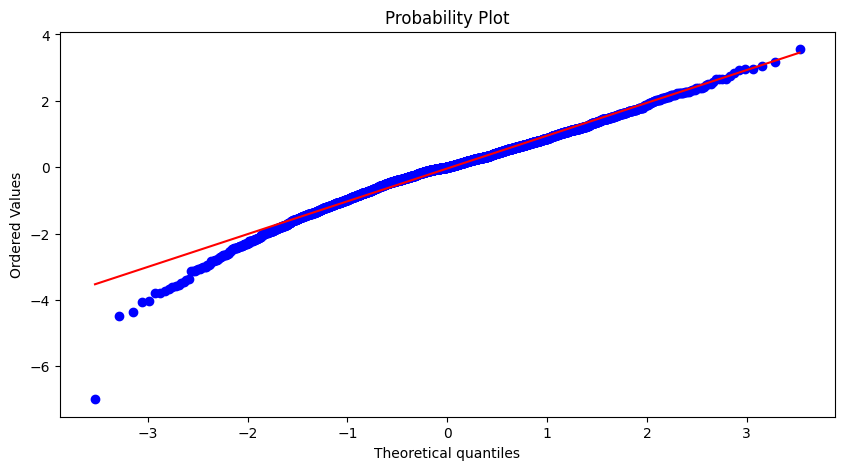

In [ ]:
# Q-plots to determine the distribution of the errors
plt.figure(figsize=(10,5))
stats.probplot(std_resid_ar2egarch11, dist=stats.t(df=3262), plot=plt)
plt.show()

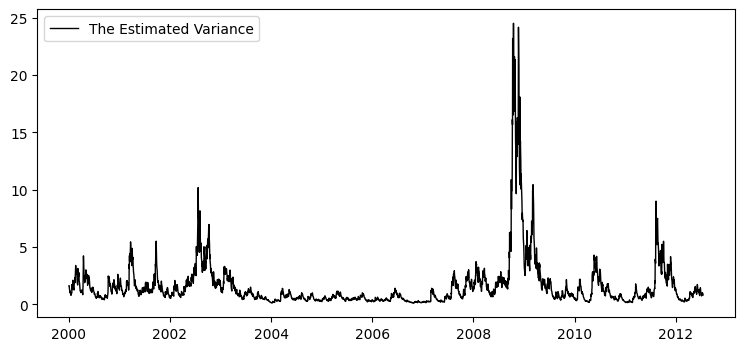

In [ ]:
estimated_var = robjects.r('fit.ar2egarch11@fit$sigma^2')
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axes.plot(pd.Series(estimated_var,index=data.index[1:]),color='black',linewidth=1,label='The Estimated Variance')
axes.legend()